# Analysis of `wandb` Logs and Metrics
This notebook collects different metrics for a specified experiment.

# Setup

In [1]:
import numpy as np
import pprint
from typing import Literal, List

import warnings

warnings.filterwarnings("ignore")

import wandb

api = wandb.Api()

import pandas as pd


In [2]:
runs = api.runs("uedyiuajxz-personal/qfl-prod-le-2")

In [3]:
groups = list(set(run.config.get("group", None) for run in runs))
print(groups)

['Standard-resnet18-qnn-14166522', 'Standard-qcnn-14378198', 'FHE-fednn-14378195', 'FHE-fednn-14288052', 'FHE-qcnn-14378199', 'Standard-resnet18-14378200', 'Standard-resnet18-14096298', 'FHE-qcnn-14166519', 'Standard-fednn-14288051', 'Standard-fedqnn-14385575', 'FHE-qcnn-14096297', 'Standard-resnet18-14166520', 'FHE-fedqnn-14166517', 'FHE-fednn-14166515', 'FHE-resnet18-qnn-14096301', 'FHE-resnet18-qnn-14288060', 'FHE-fednn-14385574', 'Standard-resnet18-qnn-14385581', 'FHE-qcnn-14385578', 'FHE-resnet18-qnn-14378203', 'FHE-resnet18-qnn-14166523', 'FHE-resnet18-14096299', 'Standard-qcnn-14096296', 'Standard-fedqnn-14288053', 'FHE-resnet18-qnn-14385582', 'Standard-resnet18-qcnn-14166524', 'FHE-fedqnn-14096295', 'FHE-fednn-14096293', 'Standard-fedqnn-14096294', 'FHE-fedqnn-14378197', 'Standard-resnet18-14288057', 'Standard-resnet18-qcnn-14096302', 'Standard-qcnn-14288055', 'FHE-resnet18-14288058', 'Standard-resnet18-qcnn-14288061', 'FHE-resnet18-14166521', 'Standard-resnet18-14385579', 'FHE

# EDA

In [4]:
group_in_focus = groups[0]

In [5]:
grouped_runs = [run for run in runs if run.config.get("group", None) == group_in_focus]
server = None
clients = []

for run in grouped_runs:
    participant = run.config.get("participant", None)
    if participant == "server":
        server = run
    else:
        clients.append(run)
    print(f"Run ID: {run.id}, Name: {run.name}, Type: {participant}")

Run ID: pg1zqw7k, Name: server, Type: server
Run ID: 0oo2iw99, Name: client16, Type: client16
Run ID: 70rf9txh, Name: client11, Type: client11
Run ID: 91h1cw6y, Name: client7, Type: client7
Run ID: aw3ozwbv, Name: client10, Type: client10
Run ID: axttnidv, Name: client0, Type: client0
Run ID: b2n6c1bv, Name: client15, Type: client15
Run ID: bc6j6r20, Name: client12, Type: client12
Run ID: db04g3ou, Name: client6, Type: client6
Run ID: dgcnlu6x, Name: client1, Type: client1
Run ID: fj7bqxpb, Name: client18, Type: client18
Run ID: kl2sns4x, Name: client9, Type: client9
Run ID: oi1r2vt7, Name: client5, Type: client5
Run ID: pguz3rom, Name: client13, Type: client13
Run ID: q3knhik1, Name: client8, Type: client8
Run ID: ruy367s4, Name: client3, Type: client3
Run ID: sccgvcum, Name: client2, Type: client2
Run ID: v8ulzwjg, Name: client17, Type: client17
Run ID: vjbwbjqm, Name: client4, Type: client4
Run ID: a1j6wbnj, Name: client14, Type: client14
Run ID: tt7o2es3, Name: client19, Type: clie

## Settings

In [6]:
pp = pprint.PrettyPrinter(indent=1, width=40)
pp.pprint(server.config)

{'batch_size': 32,
 'dataset': 'MRI',
 'fhe_enabled': False,
 'group': 'Standard-resnet18-qnn-14166522',
 'learning_rate': '1e-3',
 'model': 'resnet18-qnn',
 'number_clients': 20,
 'participant': 'server',
 'rounds': 20}


## Server and Aggregated Metrics

In [7]:
def compute_statistics(arr: np.ndarray) -> dict:
    """
    Compute basic statistical measures of an array, including mean, median, standard deviation,
    25th percentile (Q1), and 75th percentile (Q3).

    Parameters
    ----------
    arr : np.ndarray
        Input numerical array.

    Returns
    -------
    dict
        A dictionary containing the following statistics:
        - "mean" : float
            The average of the array.
        - "median" : float
            The middle value of the array.
        - "std" : float
            The standard deviation (sample standard deviation with `ddof=1`).
        - "25%" : float
            The 25th percentile (Q1).
        - "75%" : float
            The 75th percentile (Q3).

    Examples
    --------
    >>> import numpy as np
    >>> data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    >>> compute_statistics(data)
    {'mean': 55.0, 'median': 55.0, 'std': 30.276503540974915, '25%': 32.5, '75%': 77.5}
    """
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)

    stats = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std": np.std(arr, ddof=1),
        "25%": np.percentile(arr, 25),
        "75%": np.percentile(arr, 75),
        "min": np.min(arr),
        "max": np.max(arr),
        "last_value": arr[-1],
    }
    return stats

In [8]:
from rich.console import Console
from rich.table import Table

console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Server Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Server Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

server_history = server.history()
for metric in server_history.keys():
    metric_values = [val for val in server_history[metric] if not np.isnan(val)]
    stats = compute_statistics(metric_values)

    # Add row to Table 1
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )


console.print(table1)
console.print(table2)

                         Server Statistics (Part 1)                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                     ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Bytes Sent (Round)         │       9142.00 │       9142.00 │         0.00 │
│ trainable_parameters       │       2096.00 │       2096.00 │          nan │
│ parameter_aggregation_time │          0.02 │          0.02 │         0.00 │
│ round                      │         10.50 │         10.50 │         5.92 │
│ _timestamp                 │ 1747895425.85 │ 1747895498.63 │      8751.86 │
│ Total Bytes Received       │    1919820.00 │    1919820.00 │   1081696.03 │
│ loss_agg                   │          1.00 │          0.94 │         0.46 │
│ Total Bytes Sent           │      95991.00 │      95991.00 │     54084.80 │
│ metrics_central.accuracy   │         35.75 │         36.14 │         9.36 │
│ _runtime                   │      14318.58 │      14391.36 │      8751.87 │
│ Bytes Received (Round)     │     182840.00 │     182840.00 │         0.00 │
│ _step                      │         10.50 │         10.50 │         6.49 │
│ metrics_agg.precisions     │          0.59 │          0.65 │         0.25 │
│ loss_central               │          1.53 │          1.43 │         0.30 │
│ total_training_time        │      27308.55 │      27308.55 │          nan │
│ metrics_agg.accuracy       │         58.65 │         65.31 │        25.29 │
│ metrics_agg.recalls        │          0.59 │          0.65 │         0.25 │
│ metrics_agg.f1s            │          0.59 │          0.65 │         0.25 │
│ round_time                 │       1329.06 │       1331.52 │         6.91 │
└────────────────────────────┴───────────────┴───────────────┴──────────────┘

                                          Server Statistics (Part 2)                                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                     ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Bytes Sent (Round)         │       9142.00 │       9142.00 │       9142.00 │       9142.00 │       9142.00 │
│ trainable_parameters       │       2096.00 │       2096.00 │       2096.00 │       2096.00 │       2096.00 │
│ parameter_aggregation_time │          0.02 │          0.02 │          0.02 │          0.02 │          0.02 │
│ round                      │          5.75 │         15.25 │         20.00 │          1.00 │         20.00 │
│ _timestamp                 │ 1747888334.48 │ 1747902665.10 │ 1747908417.54 │ 1747881130.26 │ 1747908417.54 │
│ Total Bytes Received       │    1051330.00 │    2788310.00 │    3656800.00 │     182840.00 │    3656800.00 │
│ loss_agg                   │          0.63 │          1.26 │          2.23 │          0.44 │          2.23 │
│ Total Bytes Sent           │      52566.50 │     139415.50 │     182840.00 │       9142.00 │     182840.00 │
│ metrics_central.accuracy   │         28.73 │         39.71 │         55.54 │         20.43 │         22.26 │
│ _runtime                   │       7227.22 │      21557.82 │      27310.43 │         23.00 │      27310.43 │
│ Bytes Received (Round)     │     182840.00 │     182840.00 │     182840.00 │     182840.00 │     182840.00 │
│ _step                      │          5.25 │         15.75 │         21.00 │          0.00 │         21.00 │
│ metrics_agg.precisions     │          0.43 │          0.78 │          0.87 │          0.15 │          0.15 │
│ loss_central               │          1.35 │          1.60 │          2.39 │          1.10 │          1.78 │
│ total_training_time        │      27308.55 │      27308.55 │      27308.55 │      27308.55 │      27308.55 │
│ metrics_agg.accuracy       │         43.45 │         78.26 │         87.17 │         15.33 │         15.35 │
│ metrics_agg.recalls        │          0.43 │          0.78 │          0.87 │          0.15 │          0.15 │
│ metrics_agg.f1s            │          0.43 │          0.78 │          0.87 │          0.15 │          0.15 │
│ round_time                 │       1329.14 │       1332.18 │       1332.84 │       1302.25 │       1326.73 │
└────────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Client Metrics

In [9]:
def compute_client_statistics(client_histories):
    """
    Computes statistics for each metric by merging values across all clients.

    Parameters
    ----------
    client_histories : list[dict]
        A list of dictionaries where each dictionary contains metric history for a single client.

    Returns
    -------
    dict
        A dictionary where each key is a metric name and the value is its computed statistics.
    """
    merged_metrics = {}

    # Iterate through all client histories
    for client_history in client_histories:
        for metric, values in client_history.items():
            # Remove NaN values and flatten lists
            cleaned_values = [val for val in values if not np.isnan(val)]

            # Merge values from all clients
            if metric not in merged_metrics:
                merged_metrics[metric] = []
            merged_metrics[metric].extend(cleaned_values)

    # Compute statistics for each metric
    stats_dict = {
        metric: compute_statistics(np.array(values))
        for metric, values in merged_metrics.items()
    }

    return stats_dict


# Example: Fetch history from multiple clients
client_histories = [
    client.history() for client in clients
]  # Replace with actual client list

# Compute merged statistics
merged_stats = compute_client_statistics(client_histories)

# Display results using rich
console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Merged Client Metrics Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Merged Client Metrics Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

# Populate table with computed statistics
for metric, stats in merged_stats.items():
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )

# Display table
console.print(table1)
console.print(table2)

                 Merged Client Metrics Statistics (Part 1)                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                   ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ _step                    │      15262.20 │       6404.50 │     17809.50 │
│ _runtime                 │       6930.17 │         48.02 │      9293.98 │
│ _timestamp               │ 1747902675.99 │ 1747908452.71 │      8339.29 │
│ client_round_time        │       1300.69 │       1309.92 │        29.24 │
│ server_virtual_memory_mb │      13033.09 │      13049.43 │       250.99 │
│ client_cpu_percentage    │        234.46 │        205.10 │       145.25 │
│ client_virtual_memory_mb │       9413.66 │       9407.82 │       192.54 │
│ server_cpu_percentage    │         23.33 │          0.00 │       203.95 │
│ server_real_memory_mb    │        910.42 │        911.61 │         9.33 │
│ client_real_memory_mb    │       1009.63 │       1003.61 │        43.36 │
└──────────────────────────┴───────────────┴───────────────┴──────────────┘

                                 Merged Client Metrics Statistics (Part 2)                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                   ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ _step                    │         12.00 │      29771.00 │      54502.00 │          1.00 │      54502.00 │
│ _runtime                 │         25.48 │      13606.72 │      27254.39 │          1.38 │         53.83 │
│ _timestamp               │ 1747897475.98 │ 1747908475.33 │ 1747908499.24 │ 1747882406.01 │ 1747908499.24 │
│ client_round_time        │       1284.74 │       1323.76 │       1332.34 │       1171.74 │       1289.47 │
│ server_virtual_memory_mb │      13049.43 │      13049.43 │      13109.13 │       8998.21 │      13054.00 │
│ client_cpu_percentage    │        119.90 │        311.70 │        863.20 │          0.00 │        475.50 │
│ client_virtual_memory_mb │       9397.82 │       9426.94 │       9618.08 │       5239.31 │       9414.69 │
│ server_cpu_percentage    │          0.00 │          0.00 │       2024.00 │          0.00 │       1776.20 │
│ server_real_memory_mb    │        909.56 │        912.13 │        975.75 │        807.10 │        919.63 │
│ client_real_memory_mb    │        982.02 │       1021.27 │       1163.98 │        717.12 │       1009.82 │
└──────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Other Computations

In [10]:
some_client = clients[0]
history = some_client.history()
metric_values = [val for val in history["client_round_time"] if not np.isnan(val)]
sum(metric_values)

26064.263089179993

# Visuals and Stats for Thesis
## Globals

In [11]:
COLOR = "#A9A9A9"
KEY_ORDER = [
    "Standard-fednn",
    "FHE-fednn",
    "Standard-fedqnn",
    "FHE-fedqnn",
    "Standard-qcnn",
    "FHE-qcnn",
    "Standard-resnet18",
    "FHE-resnet18",
    "Standard-resnet18-qnn",
    "FHE-resnet18-qnn",
    "Standard-resnet18-qcnn",
]

## Training and Round Times
### Training Times

In [27]:
def get_dataframe_from_metrics_data(metrics: dict, metric_label: str) -> pd.DataFrame:
    data = []
    for client, samples in metrics.items():
        for sample in samples:
            data.append({"Model": client, metric_label: sample})
    return pd.DataFrame(data)

def get_metric_by_model_type(
        runs: List[wandb.apis.public.runs.Run],
        groups: List[str],
        metric_type: Literal["server_metric", "client_metric", "system_metric"],
        metric: str
    ) -> dict:
    metrics = {}
    for group in groups:
        try:
            if (metric in ["encryption_time", "decryption_time"]) and ("FHE" not in group):
                continue
            grouped_runs = [run for run in runs if run.config.get("group", None) == group]
            history = None
            for run in grouped_runs:
                if metric_type == "system_metric" and run.name == "system_logs":
                    history = run.history()
                elif metric_type == "server_metric" and run.config.get("participant", "") == "server":
                    history = run.history()
                elif metric_type == "client_metric" and "client" in run.config.get("participant", ""):
                    history = run.history()
                else:
                    continue

                metric_values = [
                    val
                    for val in history[metric]
                    if not np.isnan(val)
                ]

                model = "-".join(group.split("-")[:-1])
                if model in metrics.keys():
                    metrics[model] = metrics[model] + metric_values
                else:
                    metrics[model] = metric_values
        except KeyError:
            print(f"Somehow parameter was not found for group {group}.")
            continue

    metrics = {k: metrics[k] for k in KEY_ORDER if k in metrics.keys()}
    return metrics

In [13]:
training_times = get_metric_by_model_type(runs, groups, "server_metric", "total_training_time")

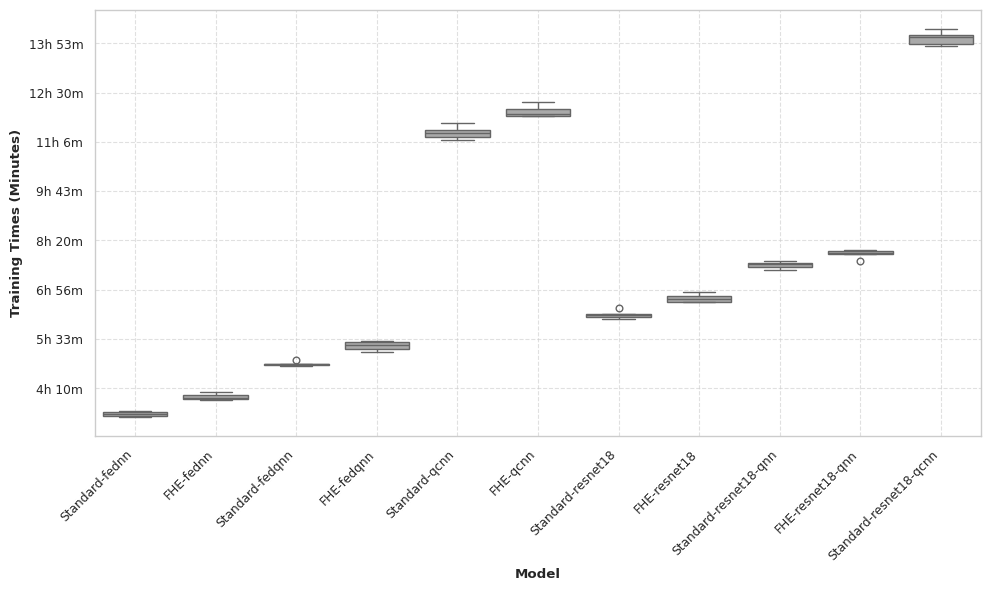

Model Training Times (Minutes)                         \
                                              count        mean        std   
5           Standard-fednn                 0.083333  206.397414   4.198245   
0                FHE-fednn                 0.083333  235.924622   5.473660   
6          Standard-fedqnn                 0.083333  291.824683   3.992422   
1               FHE-fedqnn                 0.083333  321.866503   7.601587   
8        Standard-resnet18                 0.083333  374.639014   6.709202   
3             FHE-resnet18                 0.083333  402.297008   7.237238   
10   Standard-resnet18-qnn                 0.083333  458.479619   5.980606   
4         FHE-resnet18-qnn                 0.083333  477.396852   6.979638   
7            Standard-qcnn                 0.083333  682.231256  11.585660   
2                 FHE-qcnn                 0.083333  718.046793   9.871768   
9   Standard-resnet18-qcnn                 0.083333  842.036664  11.201412   

                                                                
           min         25%         50%         75%         max  
5   201.791917  202.861942  206.059314  210.033102  211.240794  
0   230.653374  232.020477  234.180645  238.723706  244.044909  
6   288.200825  290.014760  290.946286  291.330004  298.631538  
1   311.477119  317.176311  322.951576  327.839327  329.888180  
8   367.481466  370.470732  374.291951  375.827895  385.123029  
3   395.458787  396.277331  401.146677  405.621841  412.980402  
10  449.937233  455.142418  460.389549  461.788662  465.140230  
4   465.852546  476.526360  479.203318  481.894498  483.507539  
7   669.136421  674.460103  682.090369  686.239302  699.230087  
2   709.860702  711.043893  714.054688  721.560319  733.714363  
9   829.752540  832.533730  843.752443  846.766217  857.378388

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


def format_time(seconds, _):
    if seconds < 60:
        return f"{int(seconds)}s"
    elif seconds < 3600:
        minutes = seconds // 60
        seconds = seconds % 60
        return f"{int(minutes)}m {int(seconds)}s"
    else:
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        return f"{int(hours)}h {int(minutes)}m"

def display_boxplot(metrics_df: pd.DataFrame, metric_label: str, formatter: FuncFormatter = None):
    sns.set_theme(style="whitegrid", context="paper")

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="Model", y=metric_label, data=metrics_df, color=COLOR)

    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Model", fontweight="bold")
    plt.ylabel(metric_label, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)


    if formatter:
        ax.yaxis.set_major_formatter(FuncFormatter(formatter))
    # Display the plot
    plt.tight_layout()
    plt.show()

metric_label = "Training Times (Minutes)"
df = get_dataframe_from_metrics_data(training_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

### Client Round Times

In [15]:
client_round_times = get_metric_by_model_type(runs, groups, "client_metric", "client_round_time")

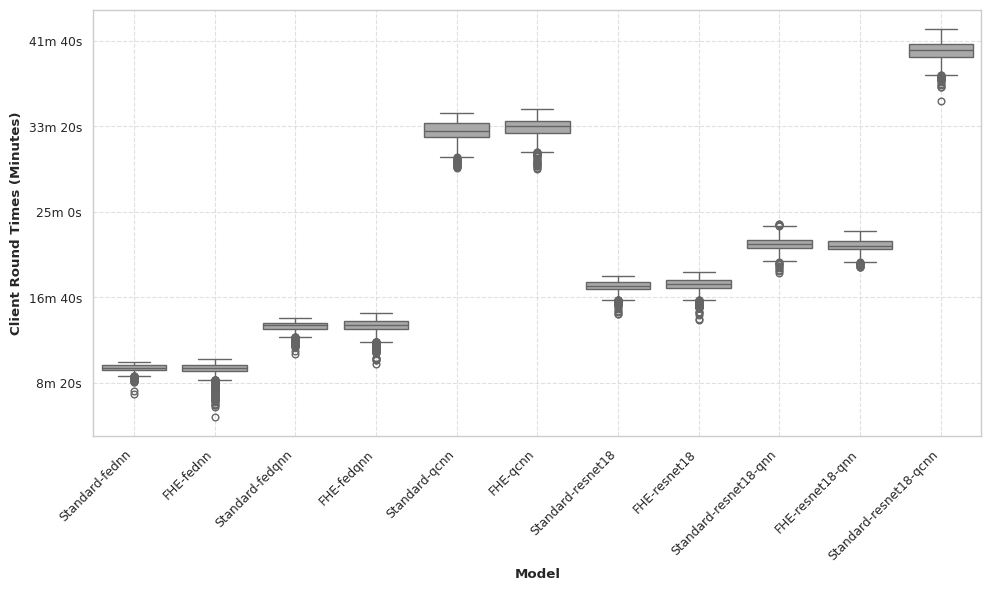

Model Client Round Times (Minutes)                       \
                                                  count       mean       std   
0                FHE-fednn                    33.333333   9.687771  0.625660   
5           Standard-fednn                    33.333333   9.818193  0.300696   
6          Standard-fedqnn                    33.333333  13.876930  0.465222   
1               FHE-fedqnn                    33.333333  13.891874  0.674002   
8        Standard-resnet18                    33.333333  17.762128  0.533725   
3             FHE-resnet18                    33.333333  17.904327  0.632366   
4         FHE-resnet18-qnn                    33.333333  21.712455  0.540821   
10   Standard-resnet18-qnn                    33.333333  21.868296  0.623483   
7            Standard-qcnn                    33.333333  32.948752  0.987532   
2                 FHE-qcnn                    33.333333  33.264183  0.955408   
9   Standard-resnet18-qcnn                    33.333333  40.713777  0.856305   

                                                           
          min        25%        50%        75%        max  
0    5.038325   9.486892   9.799829  10.040007  10.661978  
5    7.220746   9.644195   9.816323  10.057921  10.349568  
6   11.132450  13.632824  13.964829  14.171611  14.655724  
1   10.174227  13.566307  13.991692  14.368373  15.189501  
8   15.013081  17.463502  17.807555  18.154918  18.712647  
3   14.441303  17.554642  17.976781  18.329076  19.178867  
4   19.616562  21.356522  21.713544  22.162002  23.140476  
10  19.090340  21.451291  21.866156  22.315043  23.813871  
7   29.304053  32.340653  32.880883  33.679745  34.667629  
2   29.143281  32.689858  33.360062  33.914125  35.079574  
9   35.769302  40.140669  40.819056  41.343736  42.815809

In [16]:
metric_label = "Client Round Times (Minutes)"
df = get_dataframe_from_metrics_data(client_round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

### Server Round Times

In [17]:
round_times = get_metric_by_model_type(runs, groups, "server_metric", "round_time")

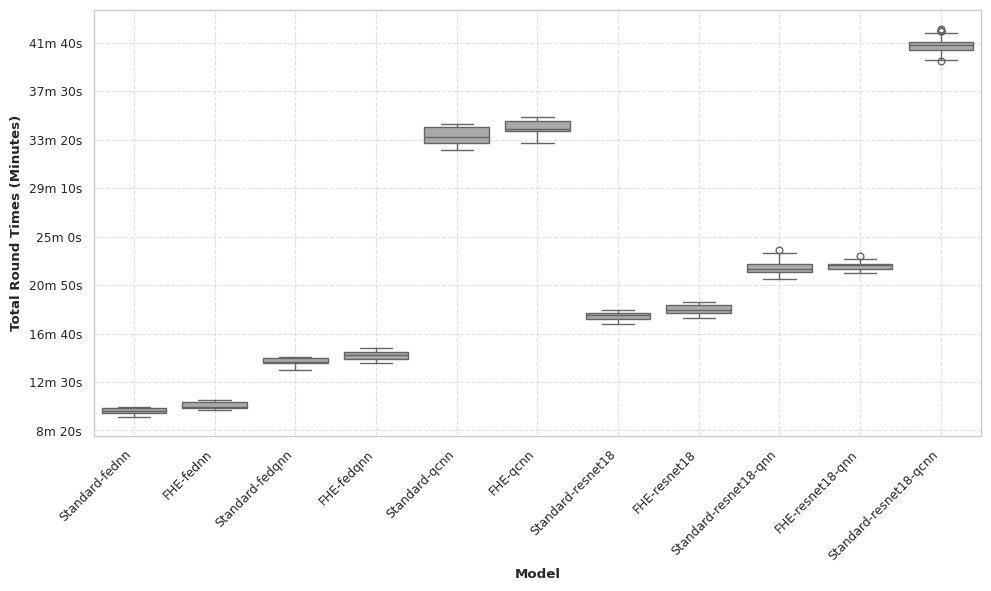

Model Total Round Times (Minutes)                       \
                                                 count       mean       std   
5           Standard-fednn                    1.666667  10.042793  0.227621   
0                FHE-fednn                    1.666667  10.464124  0.250768   
6          Standard-fedqnn                    1.666667  14.256723  0.268474   
1               FHE-fedqnn                    1.666667  14.725720  0.335946   
8        Standard-resnet18                    1.666667  18.162874  0.338306   
3             FHE-resnet18                    1.666667  18.731432  0.342975   
10   Standard-resnet18-qnn                    1.666667  22.307747  0.509249   
4         FHE-resnet18-qnn                    1.666667  22.488957  0.340155   
7            Standard-qcnn                    1.666667  33.649009  0.763629   
2                 FHE-qcnn                    1.666667  34.386367  0.579580   
9   Standard-resnet18-qcnn                    1.666667  41.370287  0.637975   

                                                           
          min        25%        50%        75%        max  
5    9.507527   9.804808  10.017689  10.248815  10.357953  
0   10.122357  10.280817  10.359595  10.799868  10.950722  
6   13.490200  14.093551  14.202489  14.549571  14.666329  
1   14.158676  14.464546  14.801658  15.036865  15.383286  
8   17.482525  17.951248  18.220323  18.394247  18.720950  
3   17.962672  18.440515  18.677284  19.081555  19.379077  
10  21.336466  21.969167  22.212131  22.640861  23.842173  
4   21.884533  22.216422  22.582786  22.652284  23.338939  
7   32.456627  33.037717  33.559831  34.456550  34.675579  
2   33.033028  34.033413  34.208468  34.975974  35.276056  
9   40.100908  41.075732  41.482929  41.703531  42.828957

In [18]:
metric_label = "Total Round Times (Minutes)"
df = get_dataframe_from_metrics_data(round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

## CPU Usage

In [19]:
client_cpu_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_cpu_percentage")

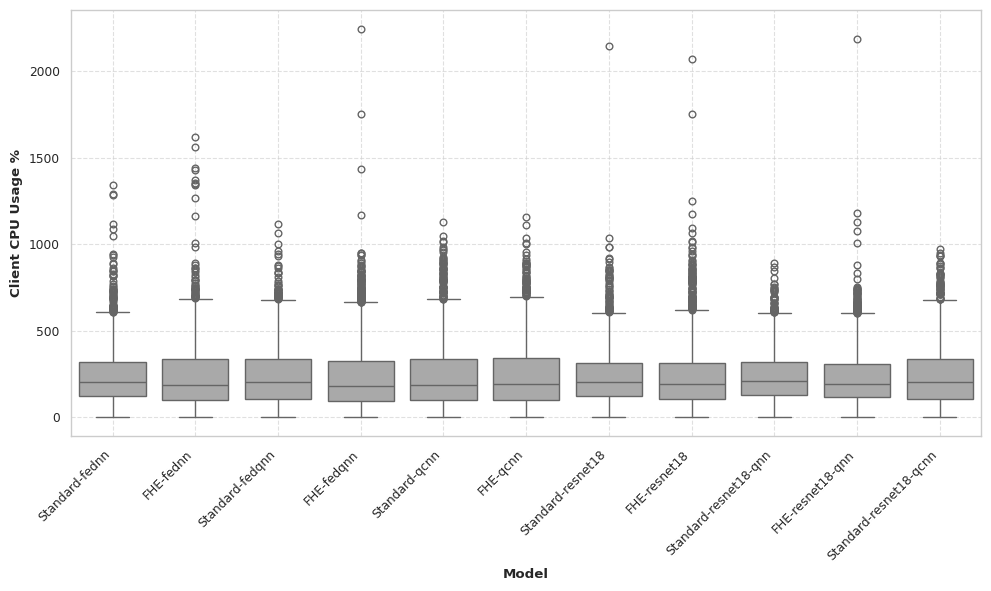

Client CPU Usage %                               \
                                    count        mean         std  min   
Model                                                                    
FHE-fednn                          2095.0  234.561957  188.341188  2.0   
FHE-fedqnn                         2216.0  230.713132  192.412510  2.0   
FHE-qcnn                           2380.0  240.019034  181.298139  2.0   
FHE-resnet18                       2326.0  237.093637  183.125408  2.0   
FHE-resnet18-qnn                   2367.0  228.837896  158.562132  2.0   
Standard-fednn                     2324.0  237.386360  157.942777  2.0   
Standard-fedqnn                    2331.0  241.943200  165.938939  2.0   
Standard-qcnn                      2430.0  237.165103  180.432446  2.0   
Standard-resnet18                  2298.0  236.349652  159.882663  2.0   
Standard-resnet18-qcnn             2455.0  240.262322  171.123325  2.0   
Standard-resnet18-qnn              2419.0  235.728938  137.314264  2.0   

                                                         
                           25%     50%      75%     max  
Model                                                    
FHE-fednn                99.50  185.80  333.700  1618.1  
FHE-fedqnn               95.90  178.55  323.625  2243.2  
FHE-qcnn                 99.90  191.80  339.700  1154.8  
FHE-resnet18            107.50  193.80  311.600  2071.8  
FHE-resnet18-qnn        113.90  191.80  308.700  2186.5  
Standard-fednn          122.95  203.80  317.400  1344.7  
Standard-fedqnn         105.90  205.50  335.650  1116.8  
Standard-qcnn            99.90  187.70  333.700  1129.0  
Standard-resnet18       123.90  204.45  315.700  2147.6  
Standard-resnet18-qcnn  105.90  201.80  335.350   971.0  
Standard-resnet18-qnn   127.90  207.80  317.400   891.2

In [20]:
metric_label = "Client CPU Usage %"
df = get_dataframe_from_metrics_data(client_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)
df.groupby("Model").describe()

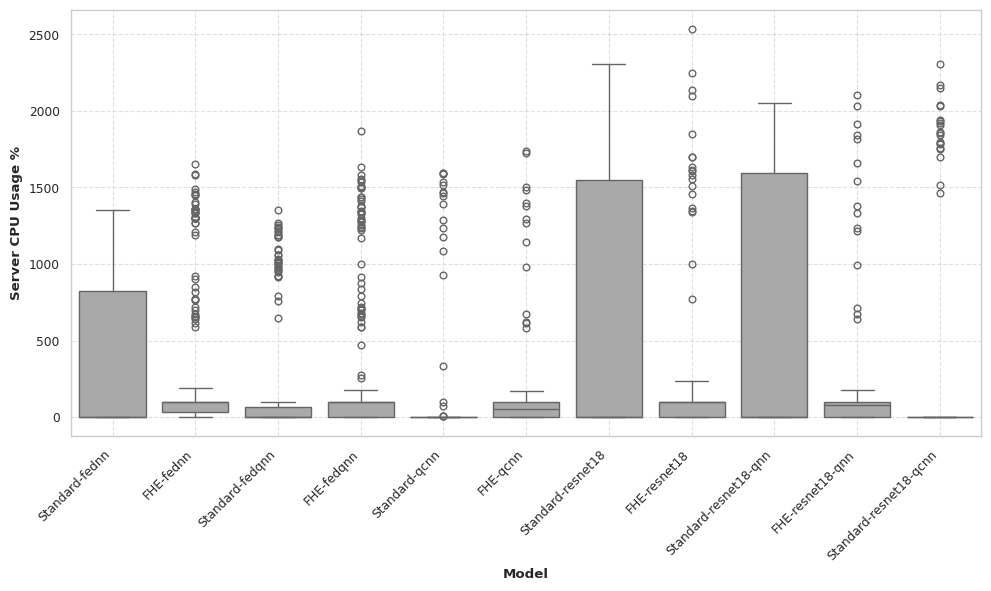

Server CPU Usage %                                     \
                                    count        mean         std  min   25%   
Model                                                                          
FHE-fednn                           410.0  190.415366  359.738259  2.0  32.0   
FHE-fedqnn                          383.0  197.415144  385.660784  2.0   2.0   
FHE-qcnn                            226.0  118.441593  292.757451  2.0   2.0   
FHE-resnet18                        323.0  153.989474  386.856810  1.9   2.0   
FHE-resnet18-qnn                    305.0  122.803934  314.597714  2.0   2.0   
Standard-fednn                      145.0  284.297241  463.191856  2.0   2.0   
Standard-fedqnn                     148.0  246.758784  450.423023  2.0   2.0   
Standard-qcnn                       110.0  181.846364  466.108872  2.0   2.0   
Standard-resnet18                   137.0  524.877372  848.187154  2.0   2.0   
Standard-resnet18-qcnn              103.0  365.998058  750.305377  2.0   2.0   
Standard-resnet18-qnn               158.0  499.583544  807.236836  1.9   2.0   

                                                
                         50%       75%     max  
Model                                           
FHE-fednn               97.9    99.900  1652.3  
FHE-fedqnn              97.9    99.900  1865.9  
FHE-qcnn                52.9    99.900  1738.2  
FHE-resnet18            97.9    99.900  2534.2  
FHE-resnet18-qnn        81.9    99.900  2103.6  
Standard-fednn           2.0   823.300  1354.9  
Standard-fedqnn          2.0    67.975  1352.8  
Standard-qcnn            2.0     2.000  1596.5  
Standard-resnet18        2.0  1548.100  2307.4  
Standard-resnet18-qcnn   2.0     2.000  2305.8  
Standard-resnet18-qnn    2.0  1596.675  2054.0

In [21]:
server_cpu_usage = get_metric_by_model_type(runs, groups, "system_metric", "server_cpu_percentage")
metric_label = "Server CPU Usage %"
df = get_dataframe_from_metrics_data(server_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)
df.groupby("Model").describe()

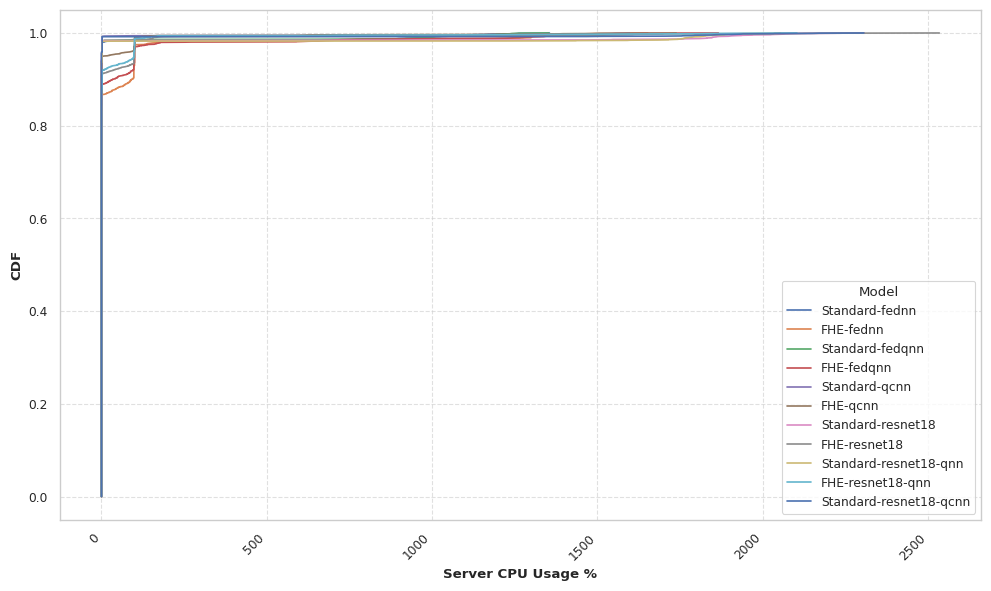

In [37]:
def display_cdf_plot(metrics_df: pd.DataFrame, metric_label: str):
    sns.set_theme(style="whitegrid", context="paper")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for model in metrics_df['Model'].unique():
        data = metrics_df[metrics_df['Model'] == model][metric_label]
        # Sort data for CDF calculation
        data_sorted = np.sort(data)
        cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        ax.plot(data_sorted, cdf, label=model)
    
    plt.xticks(rotation=45, ha="right")
    plt.xlabel(metric_label, fontweight="bold")
    plt.ylabel("CDF", fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)
    
    ax.legend(title='Model')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
display_cdf_plot(df, metric_label)

# RAM Usage

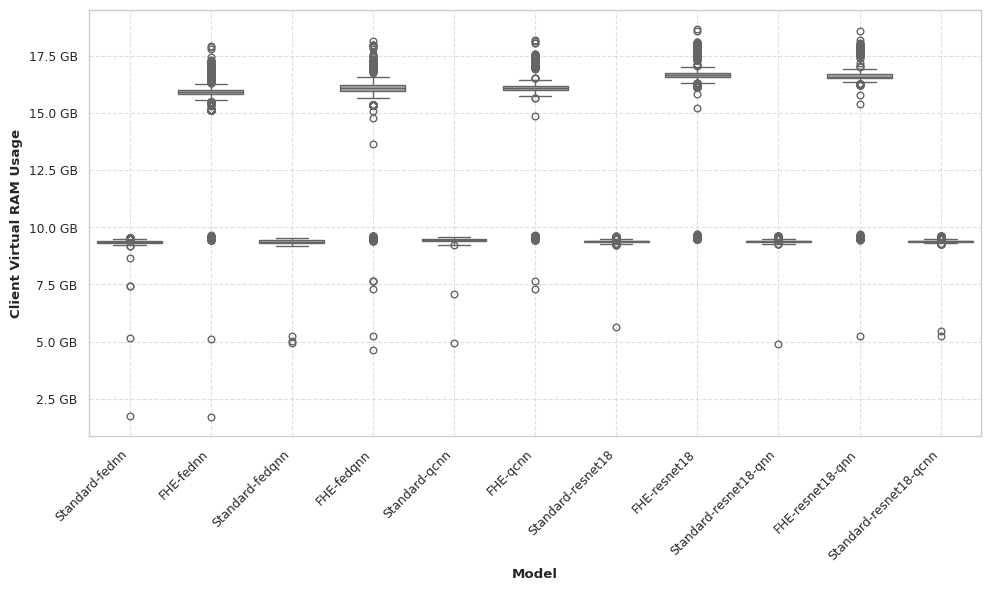

Client Virtual RAM Usage                             \
                                          count          mean          std   
Model                                                                        
FHE-fednn                                2428.0  15779.115565  1363.450862   
FHE-fedqnn                               2474.0  15851.278912  1570.695741   
FHE-qcnn                                 2497.0  15879.116488  1385.218747   
FHE-resnet18                             2491.0  16358.923880  1657.921766   
FHE-resnet18-qnn                         2497.0  16354.460552  1537.848566   
Standard-fednn                           2465.0   9353.751077   193.040958   
Standard-fedqnn                          2484.0   9370.309376   161.819898   
Standard-qcnn                            2487.0   9429.202151   118.775388   
Standard-resnet18                        2496.0   9390.496470    92.427475   
Standard-resnet18-qcnn                   2499.0   9391.616243   123.100192   
Standard-resnet18-qnn                    2493.0   9392.582300   104.088771   

                                                                                
                             min         25%         50%        75%        max  
Model                                                                           
FHE-fednn               1706.203  15843.1720  15938.6020  16033.547  17945.277  
FHE-fedqnn              4650.047  15974.0550  16105.6565  16239.473  18140.414  
FHE-qcnn                7308.316  15997.0470  16095.7420  16189.176  18192.059  
FHE-resnet18            9469.312  16585.0200  16653.6370  16766.492  18674.922  
FHE-resnet18-qnn        5238.438  16537.2620  16601.9180  16707.375  18593.773  
Standard-fednn          1750.770   9318.9920   9349.3670   9387.090   9555.410  
Standard-fedqnn         4954.836   9325.8400   9363.6290   9429.875   9534.574  
Standard-qcnn           4931.129   9381.9770   9451.4650   9482.635   9561.297  
Standard-resnet18       5653.430   9356.1765   9389.4260   9416.553   9608.375  
Standard-resnet18-qcnn  5239.379   9366.4065   9391.2300   9415.316   9628.812  
Standard-resnet18-qnn   4913.301   9359.0430   9389.5430   9416.539   9626.129

In [22]:
def format_usage(usage_mb, _):
    if usage_mb < 1_000:
        return f"{int(usage_mb)} MB"
    else:
        gb = round(usage_mb / 1_000, 2)
        return f"{gb} GB"
    
client_vir_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_virtual_memory_mb")
metric_label = "Client Virtual RAM Usage"
df = get_dataframe_from_metrics_data(client_vir_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

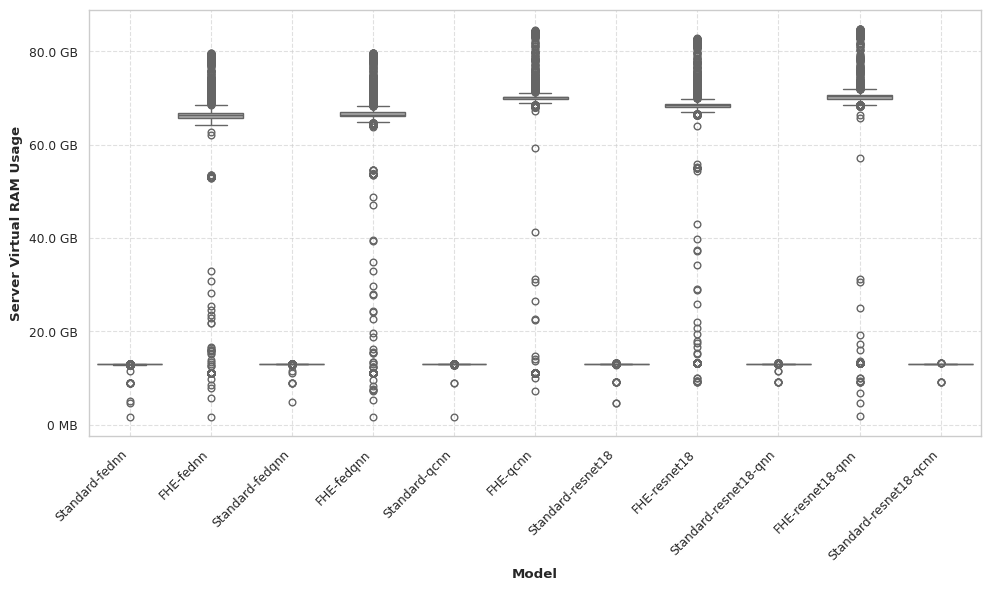

Server Virtual RAM Usage                              \
                                          count          mean           std   
Model                                                                         
FHE-fednn                                2440.0  64897.309884  12436.083592   
FHE-fedqnn                               2457.0  64612.517912  12585.518965   
FHE-qcnn                                 2500.0  67700.658261  13310.667160   
FHE-resnet18                             2492.0  66529.109215  12509.422189   
FHE-resnet18-qnn                         2500.0  67962.047873  13645.945256   
Standard-fednn                           2448.0  12910.826639    404.063181   
Standard-fedqnn                          2423.0  12940.985905    236.171836   
Standard-qcnn                            2500.0  12943.177320    251.728774   
Standard-resnet18                        2407.0  13022.710165    331.443732   
Standard-resnet18-qcnn                   2500.0  13056.005107    159.685203   
Standard-resnet18-qnn                    2500.0  13047.843430    181.701308   

                                                                              
                             min        25%        50%        75%        max  
Model                                                                         
FHE-fednn               1693.453  65700.281  66426.707  66846.594  79742.336  
FHE-fedqnn              1749.809  66054.570  66316.766  66964.250  79683.859  
FHE-qcnn                7159.656  69718.164  70203.094  70311.332  84585.852  
FHE-resnet18            9215.531  67992.770  68502.480  68761.168  82921.234  
FHE-resnet18-qnn        1805.395  69815.867  70396.367  70653.574  84745.941  
Standard-fednn          1707.383  12919.430  12932.387  12953.262  13026.742  
Standard-fedqnn         4818.219  12951.418  12956.043  12957.957  13091.973  
Standard-qcnn           1758.812  12940.961  12953.758  12962.957  13030.520  
Standard-resnet18       4721.902  13025.230  13049.105  13055.039  13241.910  
Standard-resnet18-qcnn  9067.918  13047.598  13062.035  13074.902  13211.523  
Standard-resnet18-qnn   9067.102  13049.434  13060.910  13063.293  13279.484

In [23]:
server_vir_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "server_virtual_memory_mb")
metric_label = "Server Virtual RAM Usage"
df = get_dataframe_from_metrics_data(server_vir_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

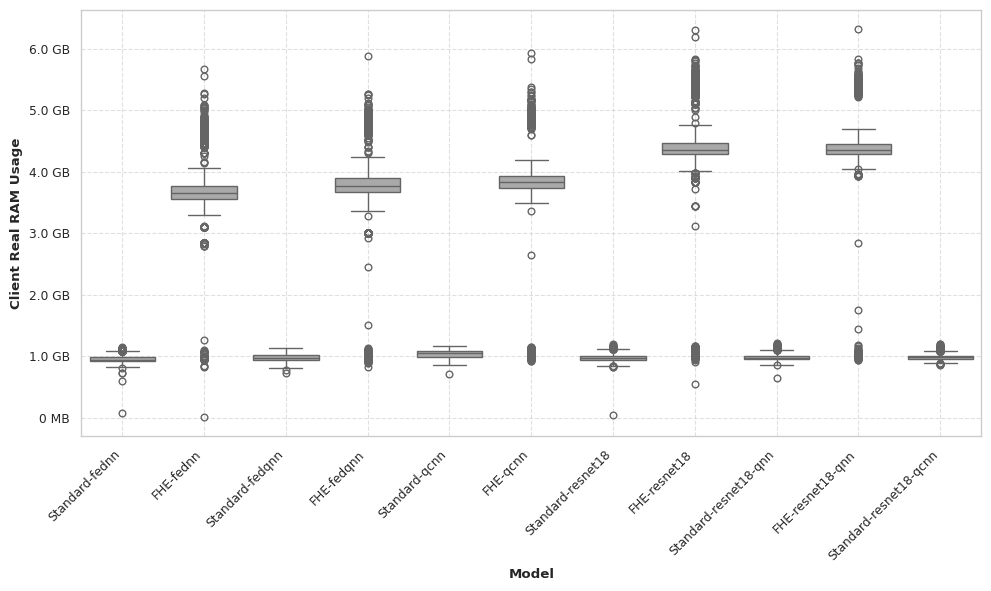

Client Real RAM Usage                           \
                                       count         mean         std   
Model                                                                   
FHE-fednn                             2454.0  3666.369353  676.396792   
FHE-fedqnn                            2473.0  3755.522795  668.385974   
FHE-qcnn                              2498.0  3758.069220  693.574111   
FHE-resnet18                          2486.0  4288.435668  775.157453   
FHE-resnet18-qnn                      2493.0  4298.731803  735.110946   
Standard-fednn                        2452.0   951.495409   57.434205   
Standard-fedqnn                       2482.0   976.311535   61.962545   
Standard-qcnn                         2484.0  1030.090931   59.964264   
Standard-resnet18                     2495.0   974.332752   55.028508   
Standard-resnet18-qcnn                2500.0   985.833671   42.901838   
Standard-resnet18-qnn                 2492.0   979.196346   51.412659   

                                                                              
                            min         25%        50%         75%       max  
Model                                                                         
FHE-fednn                11.500  3551.03100  3652.6660  3771.31225  5673.352  
FHE-fedqnn              824.094  3663.81200  3772.0660  3898.66400  5880.699  
FHE-qcnn                921.582  3740.14925  3830.6170  3930.27000  5933.547  
FHE-resnet18            546.188  4278.54800  4351.9335  4468.59650  6299.223  
FHE-resnet18-qnn        937.289  4288.98000  4351.2660  4454.41800  6315.875  
Standard-fednn           68.316   913.09000   941.8440   977.89100  1143.637  
Standard-fedqnn         720.961   928.16775   971.7580  1024.08000  1132.699  
Standard-qcnn           714.770   981.07725  1046.0995  1078.81075  1164.570  
Standard-resnet18        45.500   939.05900   970.1210  1007.01750  1189.836  
Standard-resnet18-qcnn  857.883   957.96275   983.6875  1005.77700  1203.648  
Standard-resnet18-qnn   645.602   944.91400   975.5060  1007.63975  1208.195

In [24]:
client_real_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_real_memory_mb")
metric_label = "Client Real RAM Usage"
df = get_dataframe_from_metrics_data(client_real_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

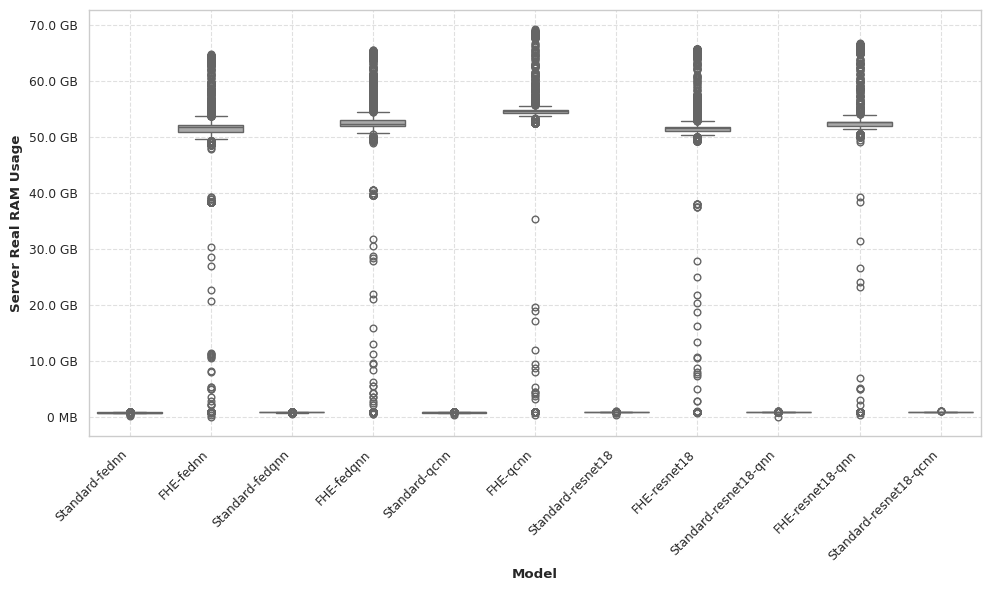

Server Real RAM Usage                              \
                                       count          mean           std   
Model                                                                      
FHE-fednn                             2458.0  49947.869681  12154.816257   
FHE-fedqnn                            2466.0  50497.815313  12299.077360   
FHE-qcnn                              2500.0  52278.938467  12622.839968   
FHE-resnet18                          2487.0  49782.469984  11397.723855   
FHE-resnet18-qnn                      2500.0  50679.546204  11646.137621   
Standard-fednn                        2432.0    804.730319     28.355106   
Standard-fedqnn                       2427.0    825.247478     22.714108   
Standard-qcnn                         2500.0    824.338781     24.453932   
Standard-resnet18                     2409.0    905.209769     32.395297   
Standard-resnet18-qcnn                2500.0    927.703783     18.838152   
Standard-resnet18-qnn                 2500.0    919.813950     24.426092   

                                                                             
                            min        25%        50%        75%        max  
Model                                                                        
FHE-fednn                48.500  50998.934  51717.691  52076.637  64807.363  
FHE-fedqnn              542.305  52005.840  52338.391  52978.559  65608.660  
FHE-qcnn                410.344  54224.137  54714.605  54804.199  69271.789  
FHE-resnet18            726.578  51052.875  51622.031  51795.688  65652.582  
FHE-resnet18-qnn        376.242  51908.453  52620.875  52744.941  66715.961  
Standard-fednn          156.500    788.270    799.961    820.340    891.898  
Standard-fedqnn         528.008    820.031    827.762    833.555    965.016  
Standard-qcnn           446.312    813.219    824.543    837.309    899.305  
Standard-resnet18       375.547    891.723    910.387    917.582   1024.598  
Standard-resnet18-qcnn  886.355    912.129    930.090    943.145   1107.090  
Standard-resnet18-qnn    72.500    910.234    923.934    931.367   1131.734

In [25]:
server_real_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "server_real_memory_mb")
metric_label = "Server Real RAM Usage"
df = get_dataframe_from_metrics_data(server_real_ram_usage, metric_label)
display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

# FHE

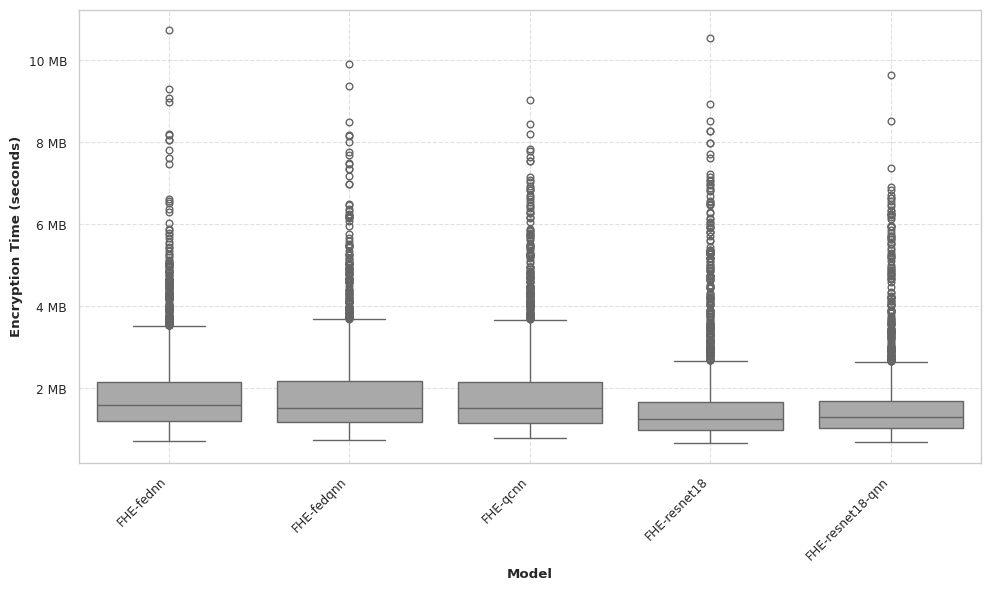

Encryption Time (seconds)                                \
                                     count      mean       std       min   
Model                                                                      
FHE-fednn                           2000.0  1.873207  1.053132  0.716592   
FHE-fedqnn                          2000.0  1.863797  1.087581  0.750992   
FHE-qcnn                            2000.0  1.874507  1.112628  0.775469   
FHE-resnet18                        2000.0  1.590038  1.116067  0.672745   
FHE-resnet18-qnn                    2000.0  1.554495  0.940024  0.687920   

                                                           
                       25%       50%       75%        max  
Model                                                      
FHE-fednn         1.213804  1.593228  2.142175  10.733194  
FHE-fedqnn        1.169908  1.523361  2.178773   9.906615  
FHE-qcnn          1.144771  1.531817  2.158925   9.029217  
FHE-resnet18      0.987157  1.256004  1.658655  10.557287  
FHE-resnet18-qnn  1.039481  1.309266  1.687874   9.634766

In [ ]:
client_encryption_time = get_metric_by_model_type(runs, groups, "client_metric", "encryption_time")
metric_label = "Encryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_encryption_time, metric_label)

display_boxplot(df, metric_label)
df.groupby("Model").describe()

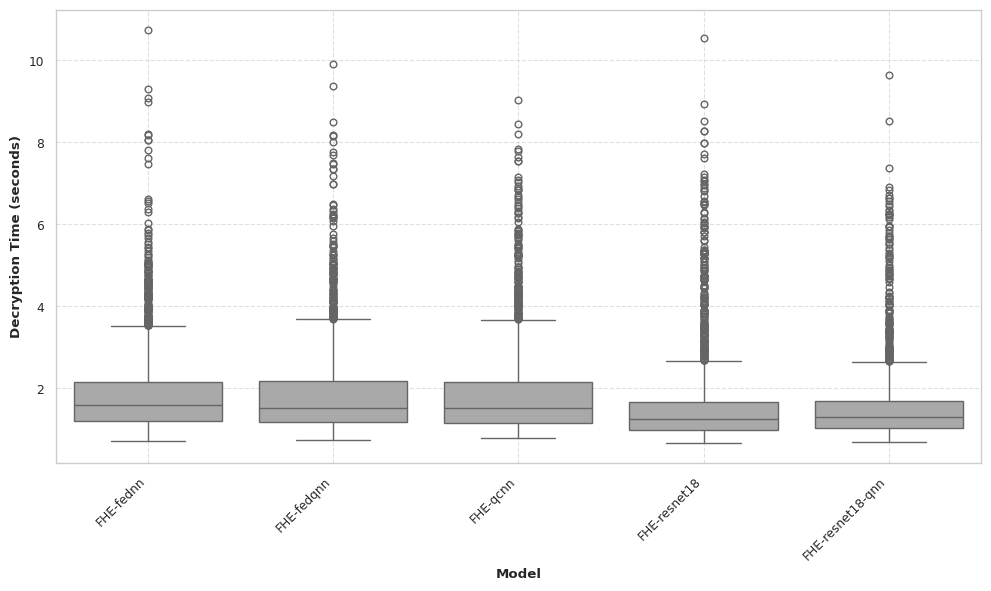

Decryption Time (seconds)                                \
                                     count      mean       std       min   
Model                                                                      
FHE-fednn                           2000.0  1.873207  1.053132  0.716592   
FHE-fedqnn                          2000.0  1.863797  1.087581  0.750992   
FHE-qcnn                            2000.0  1.874507  1.112628  0.775469   
FHE-resnet18                        2000.0  1.590038  1.116067  0.672745   
FHE-resnet18-qnn                    2000.0  1.554495  0.940024  0.687920   

                                                           
                       25%       50%       75%        max  
Model                                                      
FHE-fednn         1.213804  1.593228  2.142175  10.733194  
FHE-fedqnn        1.169908  1.523361  2.178773   9.906615  
FHE-qcnn          1.144771  1.531817  2.158925   9.029217  
FHE-resnet18      0.987157  1.256004  1.658655  10.557287  
FHE-resnet18-qnn  1.039481  1.309266  1.687874   9.634766

In [29]:
client_decryption_time = get_metric_by_model_type(runs, groups, "client_metric", "decryption_time")
metric_label = "Decryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_encryption_time, metric_label)

display_boxplot(df, metric_label)
df.groupby("Model").describe()

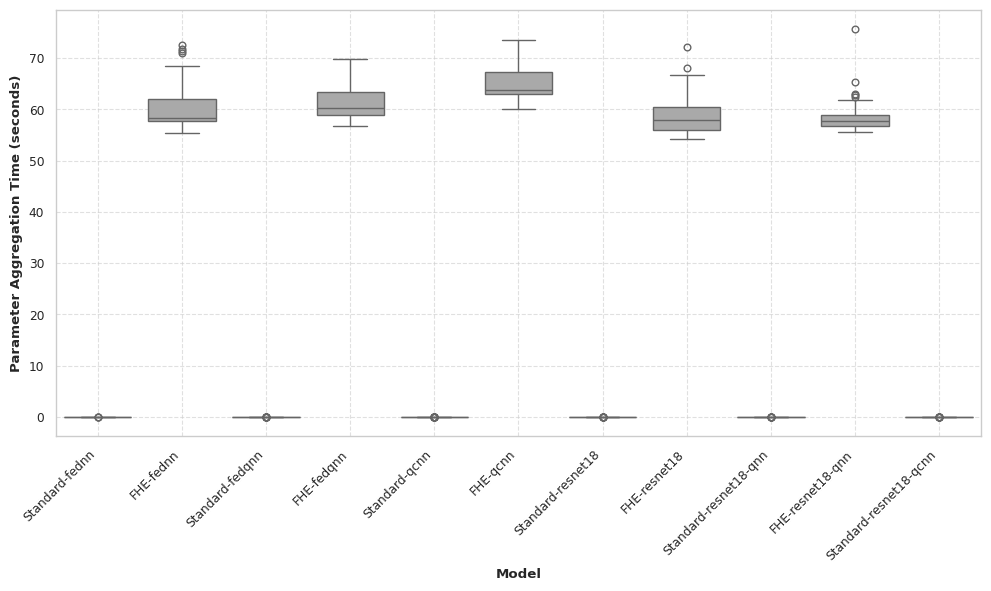

Parameter Aggregation Time (seconds)             \
                                                      count       mean   
Model                                                                    
FHE-fednn                                             100.0  59.790676   
FHE-fedqnn                                            100.0  61.168137   
FHE-qcnn                                              100.0  64.833991   
FHE-resnet18                                          100.0  58.707018   
FHE-resnet18-qnn                                      100.0  58.268315   
Standard-fednn                                        100.0   0.025263   
Standard-fedqnn                                       100.0   0.034403   
Standard-qcnn                                         100.0   0.034711   
Standard-resnet18                                     100.0   0.006675   
Standard-resnet18-qcnn                                100.0   0.015985   
Standard-resnet18-qnn                                 100.0   0.015896   

                                                                              \
                             std        min        25%        50%        75%   
Model                                                                          
FHE-fednn               3.686657  55.427822  57.701411  58.356875  62.078650   
FHE-fedqnn              3.005746  56.826933  58.980760  60.186729  63.426057   
FHE-qcnn                3.025415  60.053301  63.027990  63.736184  67.362918   
FHE-resnet18            3.595246  54.226566  55.933147  57.970505  60.534344   
FHE-resnet18-qnn        2.538673  55.592551  56.713159  57.686546  58.946140   
Standard-fednn          0.000693   0.024445   0.024848   0.025023   0.025514   
Standard-fedqnn         0.001151   0.033249   0.033799   0.034076   0.034582   
Standard-qcnn           0.001183   0.033573   0.034013   0.034377   0.034813   
Standard-resnet18       0.000187   0.006416   0.006583   0.006627   0.006706   
Standard-resnet18-qcnn  0.000219   0.015685   0.015853   0.015935   0.016027   
Standard-resnet18-qnn   0.000311   0.015483   0.015688   0.015823   0.016001   

                                   
                              max  
Model                              
FHE-fednn               72.595167  
FHE-fedqnn              69.732001  
FHE-qcnn                73.447276  
FHE-resnet18            72.099207  
FHE-resnet18-qnn        75.647678  
Standard-fednn           0.028986  
Standard-fedqnn          0.042843  
Standard-qcnn            0.040678  
Standard-resnet18        0.007984  
Standard-resnet18-qcnn   0.016755  
Standard-resnet18-qnn    0.017221

In [30]:
server_aggregation_time = get_metric_by_model_type(runs, groups, "server_metric", "parameter_aggregation_time")
metric_label = "Parameter Aggregation Time (seconds)"
df = get_dataframe_from_metrics_data(server_aggregation_time, metric_label)

display_boxplot(df, metric_label)
df.groupby("Model").describe()

# Communication Overhead

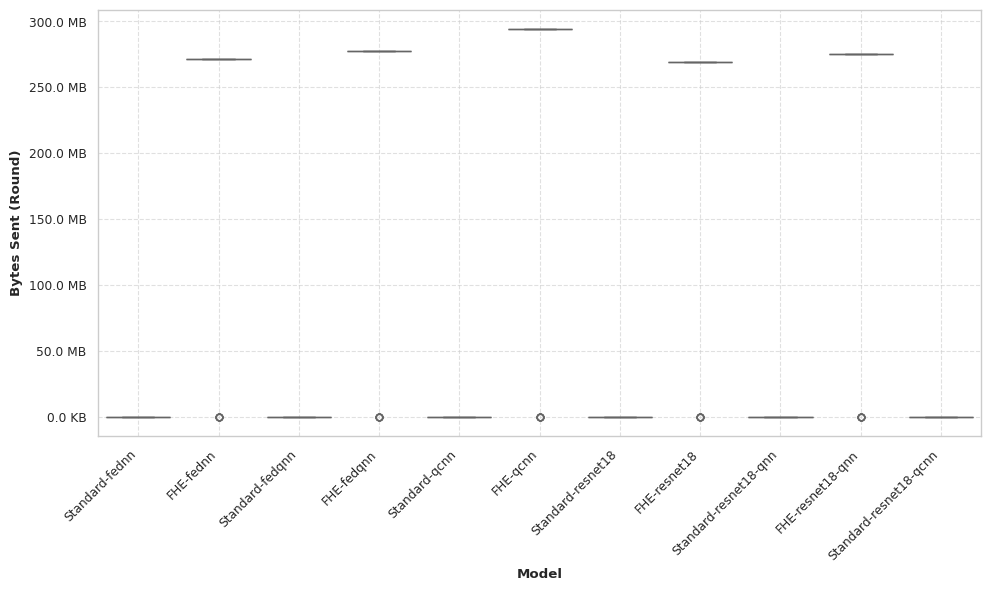

Bytes Sent (Round)                              \
                                    count          mean           std   
Model                                                                   
FHE-fednn                           100.0  2.577641e+08  5.943088e+07   
FHE-fedqnn                          100.0  2.632485e+08  6.069529e+07   
FHE-qcnn                            100.0  2.793276e+08  6.440255e+07   
FHE-resnet18                        100.0  2.557696e+08  5.897121e+07   
FHE-resnet18-qnn                    100.0  2.612541e+08  6.023563e+07   
Standard-fednn                      100.0  9.435000e+03  0.000000e+00   
Standard-fedqnn                     100.0  1.000400e+04  0.000000e+00   
Standard-qcnn                       100.0  1.052000e+04  0.000000e+00   
Standard-resnet18                   100.0  8.573000e+03  0.000000e+00   
Standard-resnet18-qcnn              100.0  1.733800e+04  0.000000e+00   
Standard-resnet18-qnn               100.0  9.142000e+03  0.000000e+00   

                                                                        \
                            min          25%          50%          75%   
Model                                                                    
FHE-fednn                9435.0  271330133.0  271330133.0  271330133.0   
FHE-fedqnn              10004.0  277103165.0  277103165.0  277103165.0   
FHE-qcnn                10520.0  294028480.0  294028480.0  294028480.0   
FHE-resnet18             8573.0  269230755.0  269230755.0  269230755.0   
FHE-resnet18-qnn         9142.0  275003787.0  275003787.0  275003787.0   
Standard-fednn           9435.0       9435.0       9435.0       9435.0   
Standard-fedqnn         10004.0      10004.0      10004.0      10004.0   
Standard-qcnn           10520.0      10520.0      10520.0      10520.0   
Standard-resnet18        8573.0       8573.0       8573.0       8573.0   
Standard-resnet18-qcnn  17338.0      17338.0      17338.0      17338.0   
Standard-resnet18-qnn    9142.0       9142.0       9142.0       9142.0   

                                     
                                max  
Model                                
FHE-fednn               271330133.0  
FHE-fedqnn              277103165.0  
FHE-qcnn                294028480.0  
FHE-resnet18            269230755.0  
FHE-resnet18-qnn        275003787.0  
Standard-fednn               9435.0  
Standard-fedqnn             10004.0  
Standard-qcnn               10520.0  
Standard-resnet18            8573.0  
Standard-resnet18-qcnn      17338.0  
Standard-resnet18-qnn        9142.0

In [40]:
def format_bytes(bytes, _):
    if bytes < 1_000_000:
        value = round(int(bytes) * 0.001, 2)
        return f"{value} KB"
    if bytes < 1_000_000_000:
        value = round(int(bytes) * 0.000001, 2)
        return f"{value} MB"
    else:
        value = round(int(bytes) * 1e-9, 2)
        return f"{value} GB"
    
server_bytes_sent = get_metric_by_model_type(runs, groups, "server_metric", "Bytes Sent (Round)")
metric_label = "Bytes Sent (Round)"
df = get_dataframe_from_metrics_data(server_bytes_sent, metric_label)

display_boxplot(df, metric_label, format_bytes)
df.groupby("Model").describe()

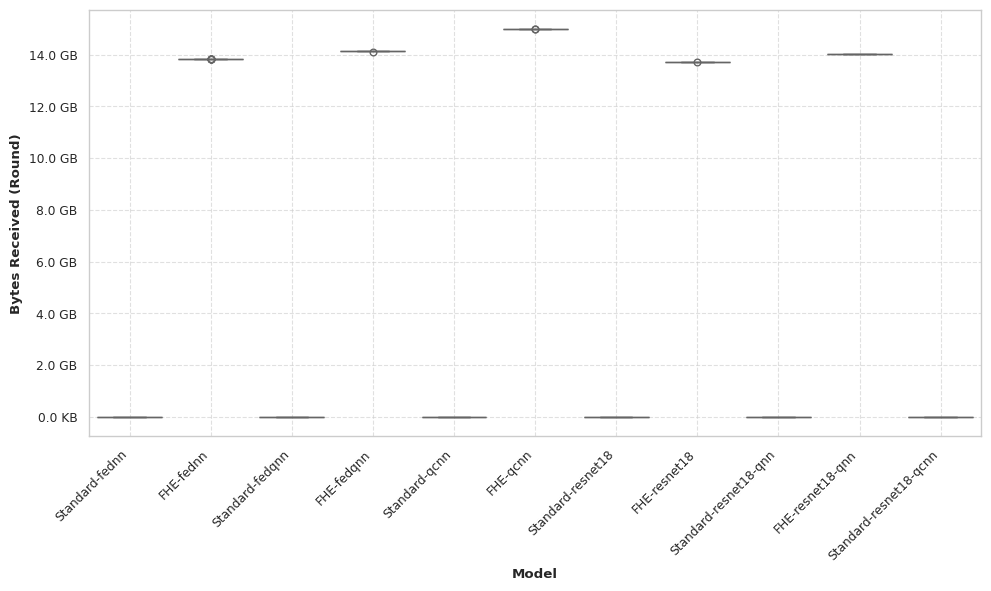

Bytes Received (Round)                              \
                                        count          mean           std   
Model                                                                       
FHE-fednn                               100.0  1.382569e+10  36938.063433   
FHE-fedqnn                              100.0  1.411986e+10  38749.213359   
FHE-qcnn                                100.0  1.498229e+10  44029.084480   
FHE-resnet18                            100.0  1.371872e+10  42268.551286   
FHE-resnet18-qnn                        100.0  1.401289e+10  39523.675248   
Standard-fednn                          100.0  1.887000e+05      0.000000   
Standard-fedqnn                         100.0  2.000800e+05      0.000000   
Standard-qcnn                           100.0  2.104000e+05      0.000000   
Standard-resnet18                       100.0  1.714600e+05      0.000000   
Standard-resnet18-qcnn                  100.0  3.467600e+05      0.000000   
Standard-resnet18-qnn                   100.0  1.828400e+05      0.000000   

                                                                  \
                                 min           25%           50%   
Model                                                              
FHE-fednn               1.382558e+10  1.382567e+10  1.382569e+10   
FHE-fedqnn              1.411972e+10  1.411984e+10  1.411986e+10   
FHE-qcnn                1.498215e+10  1.498226e+10  1.498229e+10   
FHE-resnet18            1.371864e+10  1.371869e+10  1.371872e+10   
FHE-resnet18-qnn        1.401281e+10  1.401285e+10  1.401289e+10   
Standard-fednn          1.887000e+05  1.887000e+05  1.887000e+05   
Standard-fedqnn         2.000800e+05  2.000800e+05  2.000800e+05   
Standard-qcnn           2.104000e+05  2.104000e+05  2.104000e+05   
Standard-resnet18       1.714600e+05  1.714600e+05  1.714600e+05   
Standard-resnet18-qcnn  3.467600e+05  3.467600e+05  3.467600e+05   
Standard-resnet18-qnn   1.828400e+05  1.828400e+05  1.828400e+05   

                                                    
                                 75%           max  
Model                                               
FHE-fednn               1.382571e+10  1.382578e+10  
FHE-fedqnn              1.411989e+10  1.411995e+10  
FHE-qcnn                1.498232e+10  1.498238e+10  
FHE-resnet18            1.371875e+10  1.371885e+10  
FHE-resnet18-qnn        1.401292e+10  1.401299e+10  
Standard-fednn          1.887000e+05  1.887000e+05  
Standard-fedqnn         2.000800e+05  2.000800e+05  
Standard-qcnn           2.104000e+05  2.104000e+05  
Standard-resnet18       1.714600e+05  1.714600e+05  
Standard-resnet18-qcnn  3.467600e+05  3.467600e+05  
Standard-resnet18-qnn   1.828400e+05  1.828400e+05

In [41]:
server_bytes_received = get_metric_by_model_type(runs, groups, "server_metric", "Bytes Received (Round)")
metric_label = "Bytes Received (Round)"
df = get_dataframe_from_metrics_data(server_bytes_received, metric_label)

display_boxplot(df, metric_label, format_bytes)
df.groupby("Model").describe()

In [53]:
server_total_bytes_sent = get_metric_by_model_type(runs, groups, "server_metric", "Total Bytes Sent")
metric_label = "Total Bytes Sent"
df = get_dataframe_from_metrics_data(server_total_bytes_sent, metric_label)

for model in KEY_ORDER:
    print(f"{model}: {format_bytes(max(df[df["Model"] == model]["Total Bytes Sent"]), _)}")

df.groupby("Model").describe()

Standard-fednn: 188.7 KB
FHE-fednn: 5.16 GB
Standard-fedqnn: 200.08 KB
FHE-fedqnn: 5.26 GB
Standard-qcnn: 210.4 KB
FHE-qcnn: 5.59 GB
Standard-resnet18: 171.46 KB
FHE-resnet18: 5.12 GB
Standard-resnet18-qnn: 182.84 KB
FHE-resnet18-qnn: 5.23 GB
Standard-resnet18-qcnn: 346.76 KB


Total Bytes Sent                                       \
                                  count          mean           std      min   
Model                                                                          
FHE-fednn                         100.0  2.577646e+09  1.572448e+09   9435.0   
FHE-fedqnn                        100.0  2.632490e+09  1.605904e+09  10004.0   
FHE-qcnn                          100.0  2.793281e+09  1.703992e+09  10520.0   
FHE-resnet18                      100.0  2.557701e+09  1.560281e+09   8573.0   
FHE-resnet18-qnn                  100.0  2.612545e+09  1.593738e+09   9142.0   
Standard-fednn                    100.0  9.906750e+04  5.467895e+04   9435.0   
Standard-fedqnn                   100.0  1.050420e+05  5.797649e+04  10004.0   
Standard-qcnn                     100.0  1.104600e+05  6.096688e+04  10520.0   
Standard-resnet18                 100.0  9.001650e+04  4.968337e+04   8573.0   
Standard-resnet18-qcnn            100.0  1.820490e+05  1.004794e+05  17338.0   
Standard-resnet18-qnn             100.0  9.599100e+04  5.298091e+04   9142.0   

                                                                                
                                 25%           50%           75%           max  
Model                                                                           
FHE-fednn               1.288828e+09  2.577646e+09  3.866464e+09  5.155282e+09  
FHE-fedqnn              1.316250e+09  2.632490e+09  3.948730e+09  5.264970e+09  
FHE-qcnn                1.396646e+09  2.793281e+09  4.189916e+09  5.586552e+09  
FHE-resnet18            1.278855e+09  2.557701e+09  3.836547e+09  5.115393e+09  
FHE-resnet18-qnn        1.306277e+09  2.612545e+09  3.918813e+09  5.225081e+09  
Standard-fednn          5.425125e+04  9.906750e+04  1.438838e+05  1.887000e+05  
Standard-fedqnn         5.752300e+04  1.050420e+05  1.525610e+05  2.000800e+05  
Standard-qcnn           6.049000e+04  1.104600e+05  1.604300e+05  2.104000e+05  
Standard-resnet18       4.929475e+04  9.001650e+04  1.307382e+05  1.714600e+05  
Standard-resnet18-qcnn  9.969350e+04  1.820490e+05  2.644045e+05  3.467600e+05  
Standard-resnet18-qnn   5.256650e+04  9.599100e+04  1.394155e+05  1.828400e+05

In [54]:
server_total_bytes_received = get_metric_by_model_type(runs, groups, "server_metric", "Total Bytes Received")
metric_label = "Total Bytes Received"
df = get_dataframe_from_metrics_data(server_total_bytes_received, metric_label)

for model in KEY_ORDER:
    print(f"{model}: {format_bytes(max(df[df["Model"] == model]["Total Bytes Received"]), _)}")

df.groupby("Model").describe()

Standard-fednn: 3.77 MB
FHE-fednn: 276.51 GB
Standard-fedqnn: 4.0 MB
FHE-fedqnn: 282.4 GB
Standard-qcnn: 4.21 MB
FHE-qcnn: 299.65 GB
Standard-resnet18: 3.43 MB
FHE-resnet18: 274.37 GB
Standard-resnet18-qnn: 3.66 MB
FHE-resnet18-qnn: 280.26 GB
Standard-resnet18-qcnn: 6.94 MB


Total Bytes Received                              \
                                      count          mean           std   
Model                                                                     
FHE-fednn                             100.0  1.451698e+11  8.012447e+10   
FHE-fedqnn                            100.0  1.482586e+11  8.182926e+10   
FHE-qcnn                              100.0  1.573141e+11  8.682732e+10   
FHE-resnet18                          100.0  1.440466e+11  7.950452e+10   
FHE-resnet18-qnn                      100.0  1.471353e+11  8.120931e+10   
Standard-fednn                        100.0  1.981350e+06  1.093579e+06   
Standard-fedqnn                       100.0  2.100840e+06  1.159530e+06   
Standard-qcnn                         100.0  2.209200e+06  1.219338e+06   
Standard-resnet18                     100.0  1.800330e+06  9.936674e+05   
Standard-resnet18-qcnn                100.0  3.640980e+06  2.009589e+06   
Standard-resnet18-qnn                 100.0  1.919820e+06  1.059618e+06   

                                                                  \
                                 min           25%           50%   
Model                                                              
FHE-fednn               1.382567e+10  7.949762e+10  1.451698e+11   
FHE-fedqnn              1.411983e+10  8.118921e+10  1.482586e+11   
FHE-qcnn                1.498226e+10  8.614819e+10  1.573141e+11   
FHE-resnet18            1.371871e+10  7.888257e+10  1.440466e+11   
FHE-resnet18-qnn        1.401286e+10  8.057405e+10  1.471353e+11   
Standard-fednn          1.887000e+05  1.085025e+06  1.981350e+06   
Standard-fedqnn         2.000800e+05  1.150460e+06  2.100840e+06   
Standard-qcnn           2.104000e+05  1.209800e+06  2.209200e+06   
Standard-resnet18       1.714600e+05  9.858950e+05  1.800330e+06   
Standard-resnet18-qcnn  3.467600e+05  1.993870e+06  3.640980e+06   
Standard-resnet18-qnn   1.828400e+05  1.051330e+06  1.919820e+06   

                                                    
                                 75%           max  
Model                                               
FHE-fednn               2.108419e+11  2.765141e+11  
FHE-fedqnn              2.153280e+11  2.823973e+11  
FHE-qcnn                2.284800e+11  2.996459e+11  
FHE-resnet18            2.092106e+11  2.743745e+11  
FHE-resnet18-qnn        2.136966e+11  2.802579e+11  
Standard-fednn          2.877675e+06  3.774000e+06  
Standard-fedqnn         3.051220e+06  4.001600e+06  
Standard-qcnn           3.208600e+06  4.208000e+06  
Standard-resnet18       2.614765e+06  3.429200e+06  
Standard-resnet18-qcnn  5.288090e+06  6.935200e+06  
Standard-resnet18-qnn   2.788310e+06  3.656800e+06